<a href="https://colab.research.google.com/github/phoebe-alexis/COVID_Prediction/blob/main/rf_vs_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()

KeyboardInterrupt: 

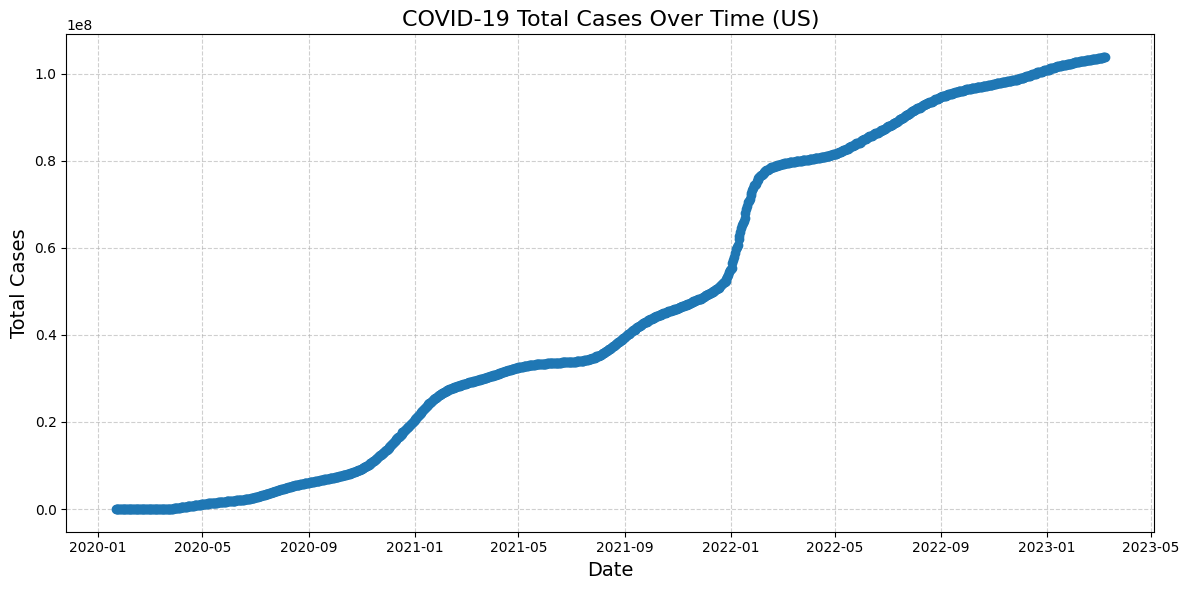

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Sum the total cases across all rows for each date
total_cases_per_date = data[date_columns].sum()

# Convert the date columns to a datetime format for proper visualization
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, total_cases_per_date, marker='o', linestyle='-', linewidth=2)
plt.title('COVID-19 Total Cases Over Time (US)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Cases', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Sum the total cases across all rows for each date
total_cases_per_date = data[date_columns].sum()

# Calculate the number of new cases per day (daily difference)
new_cases_per_date = total_cases_per_date.diff().fillna(0)

# Convert the date columns to a datetime format for proper visualization
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Plot the daily new cases
plt.figure(figsize=(12, 6))
plt.plot(dates, new_cases_per_date, marker='o', linestyle='-', linewidth=2, color='orange')
plt.title('COVID-19 New Cases Per Day (US)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('New Cases', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from datetime import datetime

# Calculate the number of days to predict from the last date in the dataset to today
last_date = dates[-1]
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
days_to_predict = (today - last_date).days

# Predict cases from the last date to today
future_cases = []
last_known_values = new_cases_per_date[-lag_days:].values

for _ in range(days_to_predict):
    # Predict the next day's cases
    next_day_cases = rf_model.predict(last_known_values.reshape(1, -1))[0]
    future_cases.append(next_day_cases)

    # Update the input with the new prediction
    last_known_values = np.roll(last_known_values, -1)
    last_known_values[-1] = next_day_cases

# Create a timeline for the predictions
future_dates = [last_date + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, new_cases_per_date, label='Historical New Cases', marker='o', linestyle='-', linewidth=2)
plt.plot(future_dates, future_cases, label='Predicted New Cases', marker='o', linestyle='--', linewidth=2, color='red')
plt.title(f'COVID-19 New Cases Prediction (Up to {today.strftime("%Y-%m-%d")})', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('New Cases', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Sum the total cases across all rows for each date
total_cases_per_date = data[date_columns].sum()

# Calculate the number of new cases per day (daily difference)
new_cases_per_date = total_cases_per_date.diff().fillna(0).values

# Convert the date columns to a datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Normalize the data
scaler = MinMaxScaler()
new_cases_scaled = scaler.fit_transform(new_cases_per_date.reshape(-1, 1))

# Create sequences of past days for LSTM input
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 100  # Number of past days to consider
X, y = create_sequences(new_cases_scaled, look_back)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict the next days up to today's date
last_known_values = new_cases_scaled[-look_back:].reshape(1, look_back, 1)
predictions = []
today = datetime.today()
days_to_predict = (today - dates[-1]).days

for _ in range(days_to_predict):
    next_day_scaled = model.predict(last_known_values)[0, 0]
    predictions.append(next_day_scaled)

    # Update input for the next prediction
    last_known_values = np.roll(last_known_values, -1, axis=1)
    last_known_values[0, -1, 0] = next_day_scaled

# Inverse scale the predictions
predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a timeline for predictions
future_dates = [dates[-1] + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Plot historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(dates, new_cases_per_date, label='Historical New Cases', marker='o', linestyle='-')
plt.plot(future_dates, predictions_unscaled, label='Predicted New Cases', marker='o', linestyle='--', color='red')
plt.title(f'COVID-19 New Cases Prediction (Up to {today.strftime("%Y-%m-%d")})', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('New Cases', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Extract the first row data (cumulative cases for a single region)
cumulative_cases_first_row = data.iloc[0, 11:].values.astype(float)

# Handle invalid values in the data
cumulative_cases_first_row = np.nan_to_num(cumulative_cases_first_row, nan=0, posinf=0, neginf=0)

# Convert the date columns to a datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases
daily_new_cases = np.diff(cumulative_cases_first_row, prepend=0)

# Normalize the daily new cases
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_new_cases.reshape(-1, 1))

# Create lagged features for daily new cases
def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 14  # Reduced lag size to focus on short-term variations
X, y = create_lagged_features(scaled_data.flatten(), lag)

# Split into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict up to today's date
last_known_values = scaled_data[-lag:].reshape(1, lag, 1)
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

future_predictions = []
for _ in range(days_to_predict):
    next_scaled = model.predict(last_known_values)[0, 0]  # Predict the next scaled value

    # Handle invalid or out-of-range predictions
    next_scaled = np.clip(next_scaled, 0, 1)  # Clip predictions to valid scaling range

    next_value = scaler.inverse_transform([[next_scaled]])[0, 0]
    future_predictions.append(next_value)

    # Update last known values
    last_known_values = np.roll(last_known_values, -1, axis=1)
    last_known_values[0, -1, 0] = next_scaled

# Add noise to introduce fluctuations in predictions
noise = np.random.normal(0, 5, size=len(future_predictions))  # Mean=0, StdDev=5
predicted_daily_new_cases_with_fluctuations = np.array(future_predictions) + noise

# Ensure no negative predictions
predicted_daily_new_cases_with_fluctuations = np.clip(predicted_daily_new_cases_with_fluctuations, 0, None)

# Convert to cumulative cases
predicted_cumulative_cases_with_fluctuations = np.cumsum(predicted_daily_new_cases_with_fluctuations) + cumulative_cases_first_row[-1]

# Generate future dates
future_dates = [last_date + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Combine actual and predicted data
extended_dates = np.concatenate([dates, future_dates])
predicted_total_cases = np.concatenate([cumulative_cases_first_row, predicted_cumulative_cases_with_fluctuations])

# Plot the results side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot daily new cases
axes[0].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[0].bar(future_dates, predicted_daily_new_cases_with_fluctuations, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[0].set_title('Daily New Cases', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('New Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot cumulative total cases
axes[1].plot(dates, cumulative_cases_first_row, label='Actual Total Cases', color='blue', alpha=0.6)
axes[1].plot(extended_dates[-len(predicted_cumulative_cases_with_fluctuations):], predicted_cumulative_cases_with_fluctuations, label='Predicted Total Cases', color='red', linestyle='--')
axes[1].set_title('Cumulative Total Cases', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Total Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the path if required
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Extract the first row data (cumulative cases for a single region)
cumulative_cases_first_row = data.iloc[0, 11:].values.astype(float)

# Handle invalid values in the data
cumulative_cases_first_row = np.nan_to_num(cumulative_cases_first_row, nan=0, posinf=0, neginf=0)

# Convert the date columns to a datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases
daily_new_cases = np.diff(cumulative_cases_first_row, prepend=0)

# Normalize the daily new cases
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_new_cases.reshape(-1, 1))

# Create lagged features for daily new cases
def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 14  # Reduced lag size to focus on short-term variations
X, y = create_lagged_features(scaled_data.flatten(), lag)

# Split into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict up to today's date
last_known_values = scaled_data[-lag:].reshape(1, lag, 1)
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

future_predictions = []
for _ in range(days_to_predict):
    next_scaled = model.predict(last_known_values)[0, 0]  # Predict the next scaled value

    # Handle invalid or out-of-range predictions
    next_scaled = np.clip(next_scaled, 0, 1)  # Clip predictions to valid scaling range

    next_value = scaler.inverse_transform([[next_scaled]])[0, 0]
    future_predictions.append(next_value)

    # Update last known values
    last_known_values = np.roll(last_known_values, -1, axis=1)
    last_known_values[0, -1, 0] = next_scaled

# Add noise to introduce fluctuations in predictions
noise = np.random.normal(0, 5, size=len(future_predictions))  # Mean=0, StdDev=5
predicted_daily_new_cases_with_fluctuations = np.array(future_predictions) + noise

# Ensure no negative predictions
predicted_daily_new_cases_with_fluctuations = np.clip(predicted_daily_new_cases_with_fluctuations, 0, None)

# Convert to cumulative cases
predicted_cumulative_cases_with_fluctuations = np.cumsum(predicted_daily_new_cases_with_fluctuations) + cumulative_cases_first_row[-1]

# Generate future dates
future_dates = [last_date + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Combine actual and predicted data
extended_dates = np.concatenate([dates, future_dates])
predicted_total_cases = np.concatenate([cumulative_cases_first_row, predicted_cumulative_cases_with_fluctuations])

# Save predictions to a DataFrame
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Daily New Cases': predicted_daily_new_cases_with_fluctuations,
    'Predicted Cumulative Cases': predicted_cumulative_cases_with_fluctuations
})

# Save to a CSV file for further use
predictions_df.to_csv('predictions.csv', index=False)

# Plot the results side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot daily new cases
axes[0].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[0].bar(future_dates, predicted_daily_new_cases_with_fluctuations, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[0].set_title('Daily New Cases', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('New Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot cumulative total cases
axes[1].plot(dates, cumulative_cases_first_row, label='Actual Total Cases', color='blue', alpha=0.6)
axes[1].plot(extended_dates[-len(predicted_cumulative_cases_with_fluctuations):], predicted_cumulative_cases_with_fluctuations, label='Predicted Total Cases', color='red', linestyle='--')
axes[1].set_title('Cumulative Total Cases', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Total Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the path if required
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Prepare the output dataset with predictions
predictions_dataset = data.copy()

# Convert the date columns to a datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')
last_date = dates[-1]
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
days_to_predict = (today - last_date).days
future_dates = [last_date + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Extract cumulative cases for all rows
cumulative_cases = data[date_columns].values.astype(float)

# Handle invalid values in the data
cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

# Calculate daily new cases for all rows
daily_new_cases = np.diff(cumulative_cases, axis=1, prepend=0)

# Normalize the daily new cases
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_new_cases.flatten().reshape(-1, 1))
scaled_data = scaled_data.reshape(daily_new_cases.shape)  # Reshape back to original shape

# Create lagged features for all rows
def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(lag, data.shape[1]):
        X.append(data[:, i - lag:i])  # Use lag days of data for all rows
        y.append(data[:, i])         # Use the current day as the target
    return np.array(X), np.array(y)

lag = 14  # Number of past days to use as input
X, y = create_lagged_features(scaled_data, lag)

# Reshape data for LSTM input
X = X.transpose((1, 0, 2))  # Reshape to [samples, timesteps, features]
y = y.transpose()           # Reshape to [samples, targets]

# Split into training and testing sets
train_size = int(X.shape[0] * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, X.shape[2])),
    LSTM(50, activation='relu'),
    Dense(X.shape[2])  # Predict for all rows simultaneously
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict future cases for all rows
last_known_values = scaled_data[:, -lag:]  # Get the last `lag` days for all rows
predictions = []

for _ in range(days_to_predict):
    # Reshape for prediction
    input_data = last_known_values.reshape(last_known_values.shape[0], lag, 1)
    next_scaled = model.predict(input_data, batch_size=16)  # Predict next step for all rows

    # Inverse scale predictions
    next_values = scaler.inverse_transform(next_scaled)
    predictions.append(next_values.flatten())

    # Update last known values
    last_known_values = np.roll(last_known_values, -1, axis=1)
    last_known_values[:, -1] = next_scaled.flatten()

# Convert predictions to cumulative cases
predictions = np.array(predictions).T  # Shape: [rows, future_days]
predicted_cumulative_cases = predictions + cumulative_cases[:, -1].reshape(-1, 1)

# Add predicted cumulative cases to the dataset
for i, future_date in enumerate(future_dates):
    predictions_dataset[future_date] = predicted_cumulative_cases[:, i]

# Save the updated dataset
output_file = 'optimized_predictions_dataset.csv'
predictions_dataset.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


ValueError: Dimensions must be equal, but are 1129 and 14 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, sequential_29_1/dense_29_1/Add)' with input shapes: [?,1129], [?,14].

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Select a single row (e.g., row 0) for prediction
row_index = 0  # Change this to the index of the desired row
cumulative_cases = data.iloc[row_index, 11:].values.astype(float)

# Handle invalid values in the data
cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

# Convert the date columns to a datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases
daily_new_cases = np.diff(cumulative_cases, prepend=0)

# Normalize the daily new cases
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_new_cases.reshape(-1, 1))

# Create lagged features for the row
def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 14  # Number of past days to use as input
X, y = create_lagged_features(scaled_data.flatten(), lag)

# Split into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Predict up to today's date
last_known_values = scaled_data[-lag:].reshape(1, lag, 1)
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

future_predictions = []
for _ in range(days_to_predict):
    next_scaled = model.predict(last_known_values)[0, 0]  # Predict the next scaled value

    # Handle invalid or out-of-range predictions
    next_scaled = np.clip(next_scaled, 0, 1)  # Clip predictions to valid scaling range

    next_value = scaler.inverse_transform([[next_scaled]])[0, 0]
    future_predictions.append(next_value)

    # Update last known values
    last_known_values = np.roll(last_known_values, -1, axis=1)
    last_known_values[0, -1, 0] = next_scaled

# Add noise to the predictions to simulate fluctuations
noise = np.random.normal(0, 5, size=len(future_predictions))  # Mean=0, StdDev=5
predicted_daily_new_cases_with_fluctuations = np.array(future_predictions) + noise

# Ensure no negative predictions
predicted_daily_new_cases_with_fluctuations = np.clip(predicted_daily_new_cases_with_fluctuations, 0, None)

# Convert to cumulative cases
predicted_cumulative_cases_with_fluctuations = np.cumsum(predicted_daily_new_cases_with_fluctuations) + cumulative_cases[-1]

# Generate future dates
future_dates = [last_date + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Combine actual and predicted data for cumulative cases
extended_dates = np.concatenate([dates, future_dates])
predicted_total_cases = np.concatenate([cumulative_cases, predicted_cumulative_cases_with_fluctuations])

# Plot cumulative total cases and daily new cases side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot cumulative total cases
axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
axes[0].plot(extended_dates[-len(predicted_cumulative_cases_with_fluctuations):], predicted_cumulative_cases_with_fluctuations, label='Predicted Total Cases', color='red', linestyle='--')
axes[0].set_title(f'Cumulative Total Cases for Row {row_index}', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Total Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot daily new cases
axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[1].bar(future_dates, predicted_daily_new_cases_with_fluctuations, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[1].set_title(f'Daily New Cases for Row {row_index}', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('New Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
# Load the dataset
file_path = 'time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Print the first row
print("First Row of the Dataset:")
print(data.iloc[0])
print(data.iloc[1])
print(data.iloc[2])


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Sum all rows to get total cases per date
cumulative_cases = data[date_columns].sum().values.astype(float)

# Handle invalid values in the data
cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

# Convert the date columns to a datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases
daily_new_cases = np.diff(cumulative_cases, prepend=0)

# Normalize the daily new cases
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_new_cases.reshape(-1, 1))

# Create lagged features for the row
def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 14  # Number of past days to use as input
X, y = create_lagged_features(scaled_data.flatten(), lag)

# Split into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Predict up to today's date
last_known_values = scaled_data[-lag:].reshape(1, lag, 1)
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

future_predictions = []
for _ in range(days_to_predict):
    next_scaled = model.predict(last_known_values)[0, 0]  # Predict the next scaled value

    # Handle invalid or out-of-range predictions
    next_scaled = np.clip(next_scaled, 0, 1)  # Clip predictions to valid scaling range

    next_value = scaler.inverse_transform([[next_scaled]])[0, 0]
    future_predictions.append(next_value)

    # Update last known values
    last_known_values = np.roll(last_known_values, -1, axis=1)
    last_known_values[0, -1, 0] = next_scaled

# Add noise to the predictions to simulate fluctuations
noise = np.random.normal(0, 5, size=len(future_predictions))  # Mean=0, StdDev=5
predicted_daily_new_cases_with_fluctuations = np.array(future_predictions) + noise

# Ensure no negative predictions
predicted_daily_new_cases_with_fluctuations = np.clip(predicted_daily_new_cases_with_fluctuations, 0, None)

# Convert to cumulative cases
predicted_cumulative_cases_with_fluctuations = np.cumsum(predicted_daily_new_cases_with_fluctuations) + cumulative_cases[-1]

# Generate future dates
future_dates = [last_date + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Combine actual and predicted data for cumulative cases
extended_dates = np.concatenate([dates, future_dates])
predicted_total_cases = np.concatenate([cumulative_cases, predicted_cumulative_cases_with_fluctuations])

# Plot cumulative total cases and daily new cases side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot cumulative total cases
axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
axes[0].plot(extended_dates[-len(predicted_cumulative_cases_with_fluctuations):], predicted_cumulative_cases_with_fluctuations, label='Predicted Total Cases', color='red', linestyle='--')
axes[0].set_title('Cumulative Total Cases', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Total Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot daily new cases
axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[1].bar(future_dates, predicted_daily_new_cases_with_fluctuations, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[1].set_title('Daily New Cases', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('New Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Sum all rows to get total cases per date
cumulative_cases = data[date_columns].sum().values.astype(float)

# Handle invalid values in the data
cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

# Convert the date columns to a datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases
daily_new_cases = np.diff(cumulative_cases, prepend=0)

# Normalize the daily new cases
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_new_cases.reshape(-1, 1))

# Create lagged features for the row
def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 120  # Number of past days to use as input
X, y = create_lagged_features(scaled_data.flatten(), lag)

# Split into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lag, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Predict up to today's date
last_known_values = scaled_data[-lag:].reshape(1, lag, 1)
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

future_predictions = []
for _ in range(days_to_predict):
    next_scaled = model.predict(last_known_values)[0, 0]  # Predict the next scaled value

    # Handle invalid or out-of-range predictions
    next_scaled = np.clip(next_scaled, 0, 1)  # Clip predictions to valid scaling range

    next_value = scaler.inverse_transform([[next_scaled]])[0, 0]
    future_predictions.append(next_value)

    # Update last known values
    last_known_values = np.roll(last_known_values, -1, axis=1)
    last_known_values[0, -1, 0] = next_scaled

# Add noise to the predictions to simulate fluctuations
noise = np.random.normal(0, 5, size=len(future_predictions))  # Mean=0, StdDev=5
predicted_daily_new_cases_with_fluctuations = np.array(future_predictions) + noise

# Ensure no negative predictions
predicted_daily_new_cases_with_fluctuations = np.clip(predicted_daily_new_cases_with_fluctuations, 0, None)

# Convert to cumulative cases
predicted_cumulative_cases_with_fluctuations = np.cumsum(predicted_daily_new_cases_with_fluctuations) + cumulative_cases[-1]

# Generate future dates
future_dates = [last_date + pd.Timedelta(days=i + 1) for i in range(days_to_predict)]

# Combine actual and predicted data for cumulative cases
extended_dates = np.concatenate([dates, future_dates])
predicted_total_cases = np.concatenate([cumulative_cases, predicted_cumulative_cases_with_fluctuations])

# Plot cumulative total cases and daily new cases side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot cumulative total cases
axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
axes[0].plot(extended_dates[-len(predicted_cumulative_cases_with_fluctuations):], predicted_cumulative_cases_with_fluctuations, label='Predicted Total Cases', color='red', linestyle='--')
axes[0].set_title('Cumulative Total Cases', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Total Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot daily new cases
axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[1].bar(future_dates, predicted_daily_new_cases_with_fluctuations, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[1].set_title('Daily New Cases', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('New Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Mean Absolute Error (MAE): 25037.087819905213
Mean Squared Error (MSE): 4303397910.418009


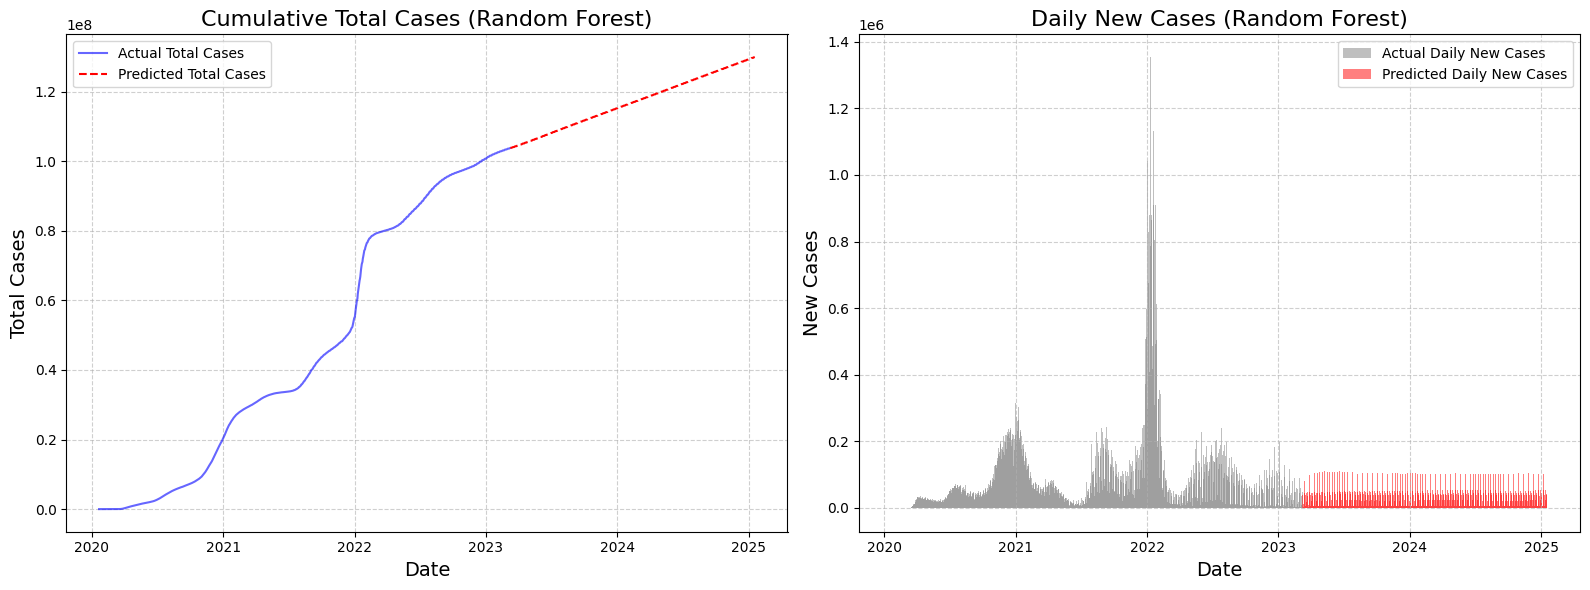

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the dataset
file_path = 'time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Sum all rows to get total cases per date
cumulative_cases = data[date_columns].sum().values.astype(float)

# Convert the date columns to datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases
daily_new_cases = np.diff(cumulative_cases, prepend=0)

# Prepare data for Random Forest
# Create lagged features
def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 90  # Use the past 14 days to predict the next day's value
X, y = create_lagged_features(daily_new_cases, lag)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Predict future daily new cases up to today's date
last_known_values = daily_new_cases[-lag:]  # Use the last `lag` days as input
future_predictions = []

today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

for _ in range(days_to_predict):
    next_day = rf_model.predict(last_known_values.reshape(1, -1))[0]
    future_predictions.append(next_day)

    # Update the input with the new prediction
    last_known_values = np.roll(last_known_values, -1)
    last_known_values[-1] = next_day

# Ensure no negative predictions
future_predictions = np.clip(future_predictions, 0, None)

# Convert predicted daily new cases to cumulative cases
predicted_cumulative_cases = np.cumsum(future_predictions) + cumulative_cases[-1]

# Generate future dates
future_dates = [last_date + timedelta(days=i + 1) for i in range(days_to_predict)]

# Plot cumulative total cases and daily new cases
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot cumulative total cases
axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
axes[0].plot(future_dates, predicted_cumulative_cases, label='Predicted Total Cases', color='red', linestyle='--')
axes[0].set_title('Cumulative Total Cases (Random Forest)', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Total Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot daily new cases
axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[1].bar(future_dates, future_predictions, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[1].set_title('Daily New Cases (Random Forest)', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('New Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


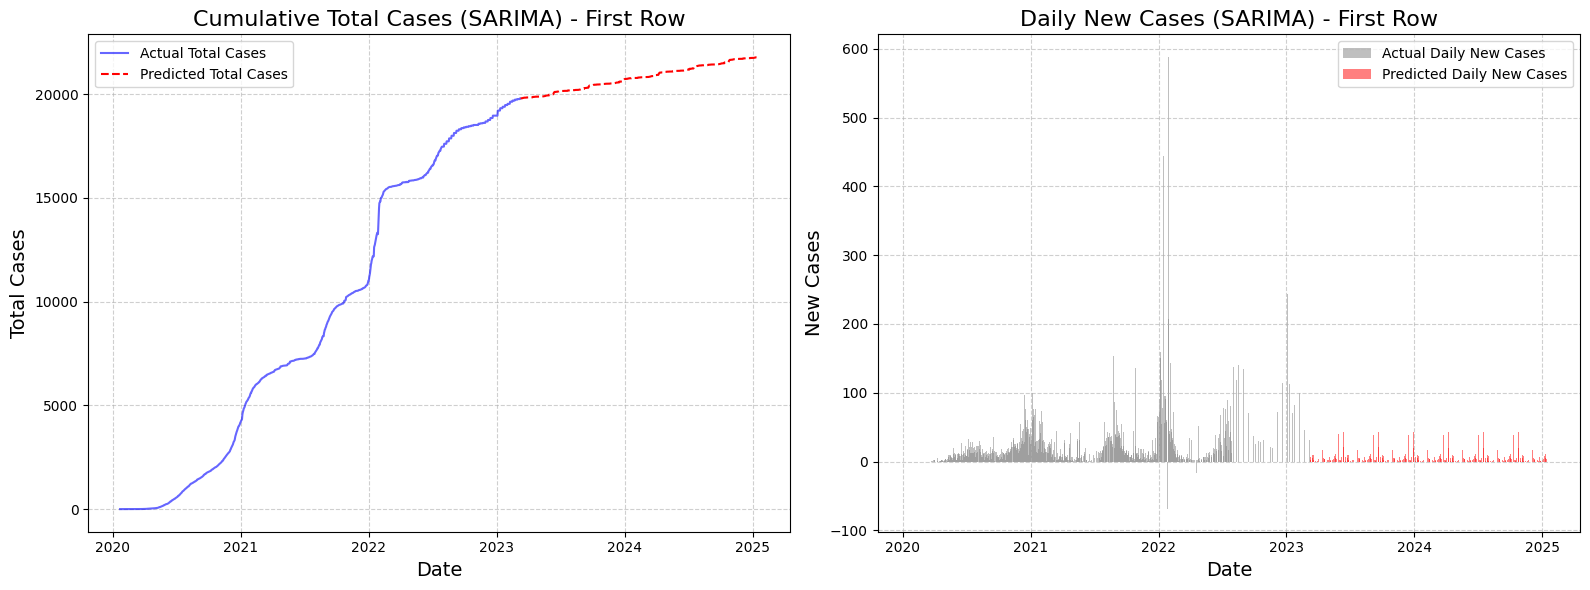

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Get cumulative cases for the first row
cumulative_cases = data.iloc[0, 11:].values.astype(float)

# Handle invalid values in the data
cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

# Convert the date columns to datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases for the first row
daily_new_cases = np.diff(cumulative_cases, prepend=0)

# Configure SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 30  # Monthly seasonality (approximated to 30 days)

# Fit SARIMA model for daily new cases
sarima_model = SARIMAX(daily_new_cases, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit(disp=False)

# Predict future daily new cases up to today's date
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

future_predictions = sarima_fit.forecast(steps=days_to_predict)

# Ensure no negative predictions
future_predictions = np.clip(future_predictions, 0, None)

# Convert predicted daily new cases to cumulative cases
predicted_cumulative_cases = np.cumsum(future_predictions) + cumulative_cases[-1]

# Generate future dates
future_dates = [last_date + timedelta(days=i + 1) for i in range(days_to_predict)]

# Plot cumulative total cases and daily new cases
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot cumulative total cases
axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
axes[0].plot(future_dates, predicted_cumulative_cases, label='Predicted Total Cases', color='red', linestyle='--')
axes[0].set_title('Cumulative Total Cases (SARIMA) - First Row', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Total Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot daily new cases
axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[1].bar(future_dates, future_predictions, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[1].set_title('Daily New Cases (SARIMA) - First Row', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('New Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Ensure the dataset contains 'Province_State' and case columns
if 'Province_State' not in data.columns:
    raise ValueError("The dataset must have a 'Province_State' column.")

# Extract the date columns (assuming the first 11 columns are metadata)
date_columns = data.columns[11:]

# Sum cases for each Province_State
province_state_sums = data.groupby('Province_State')[date_columns].sum()

# Reset index to save as a clean DataFrame
province_state_sums.reset_index(inplace=True)

# Save the new dataset
output_file = '/content/province_state_sums.csv'  # Change the file path if needed
province_state_sums.to_csv(output_file, index=False)
print(f"Dataset saved to {output_file}")

# Preview the new dataset
print(province_state_sums.head())


Dataset saved to /content/province_state_sums.csv
   Province_State  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0         Alabama        0        0        0        0        0        0   
1          Alaska        0        0        0        0        0        0   
2  American Samoa        0        0        0        0        0        0   
3         Arizona        0        0        0        0        1        1   
4        Arkansas        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  ...  2/28/23   3/1/23   3/2/23   3/3/23  \
0        0        0        0  ...  1638348  1642062  1642062  1642062   
1        0        0        0  ...   307073   307073   307073   307073   
2        0        0        0  ...     8320     8320     8320     8320   
3        1        1        1  ...  2434631  2440294  2440294  2440294   
4        0        0        0  ...  1004752  1004752  1005212  1005464   

    3/4/23   3/5/23   3/6/23   3/7/23   3/8/23   3/9/23  
0 

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta

# Load the new dataset with sums by Province_State
file_path = '/content/province_state_sums.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[1:]  # Assuming the first column is 'Province_State'

# Convert the date columns to datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Get today's date
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

# Initialize a DataFrame to store predictions
predicted_data = data.copy()

# Iterate through each state and make predictions
for index, row in data.iterrows():
    state = row['Province_State']
    print(f"Processing {state}...")

    # Get cumulative cases for the current state
    cumulative_cases = row[1:].values.astype(float)

    # Handle invalid values in the data
    cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

    # Calculate daily new cases
    daily_new_cases = np.diff(cumulative_cases, prepend=0)

    # Configure SARIMA parameters
    p, d, q = 1, 1, 1
    P, D, Q, s = 1, 1, 1, 10  # Monthly seasonality (approximated to 30 days)

    # Fit SARIMA model for daily new cases
    try:
        sarima_model = SARIMAX(daily_new_cases, order=(p, d, q), seasonal_order=(P, D, Q, s))
        sarima_fit = sarima_model.fit(disp=False)

        # Predict future daily new cases
        future_predictions = sarima_fit.forecast(steps=days_to_predict)

        # Ensure no negative predictions
        future_predictions = np.clip(future_predictions, 0, None)

        # Convert predicted daily new cases to cumulative cases
        predicted_cumulative_cases = np.cumsum(future_predictions) + cumulative_cases[-1]

        # Add predicted columns to the DataFrame
        for i, future_date in enumerate([last_date + timedelta(days=i + 1) for i in range(days_to_predict)]):
            predicted_data.loc[index, str(future_date.date())] = predicted_cumulative_cases[i]

    except Exception as e:
        print(f"Error processing {state}: {e}")
        continue

# Save the updated dataset
output_file = '/content/province_state_predictions.csv'  # Adjust the file path if needed
predicted_data.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")


Processing Alabama...


<ipython-input-14-06e84c702d44>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predicted_data.loc[index, str(future_date.date())] = predicted_cumulative_cases[i]
<ipython-input-14-06e84c702d44>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predicted_data.loc[index, str(future_date.date())] = predicted_cumulative_cases[i]
<ipython-input-14-06e84c702d44>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

Processing Alaska...
Processing American Samoa...
Processing Arizona...
Processing Arkansas...
Processing California...
Processing Colorado...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Connecticut...
Processing Delaware...
Processing Diamond Princess...
Processing District of Columbia...
Processing Florida...
Processing Georgia...
Processing Grand Princess...
Processing Guam...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Hawaii...
Processing Idaho...
Processing Illinois...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Indiana...
Processing Iowa...
Processing Kansas...
Processing Kentucky...
Processing Louisiana...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Maine...
Processing Maryland...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Massachusetts...
Processing Michigan...
Processing Minnesota...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Mississippi...
Processing Missouri...
Processing Montana...
Processing Nebraska...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Nevada...
Processing New Hampshire...
Processing New Jersey...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing New Mexico...
Processing New York...
Processing North Carolina...
Processing North Dakota...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Northern Mariana Islands...
Processing Ohio...
Processing Oklahoma...
Processing Oregon...
Processing Pennsylvania...
Processing Puerto Rico...
Processing Rhode Island...
Processing South Carolina...
Processing South Dakota...
Processing Tennessee...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Texas...
Processing Utah...
Processing Vermont...
Processing Virgin Islands...
Processing Virginia...
Processing Washington...
Processing West Virginia...
Processing Wisconsin...
Processing Wyoming...
Predictions saved to /content/province_state_predictions.csv


GUI to visualize state data


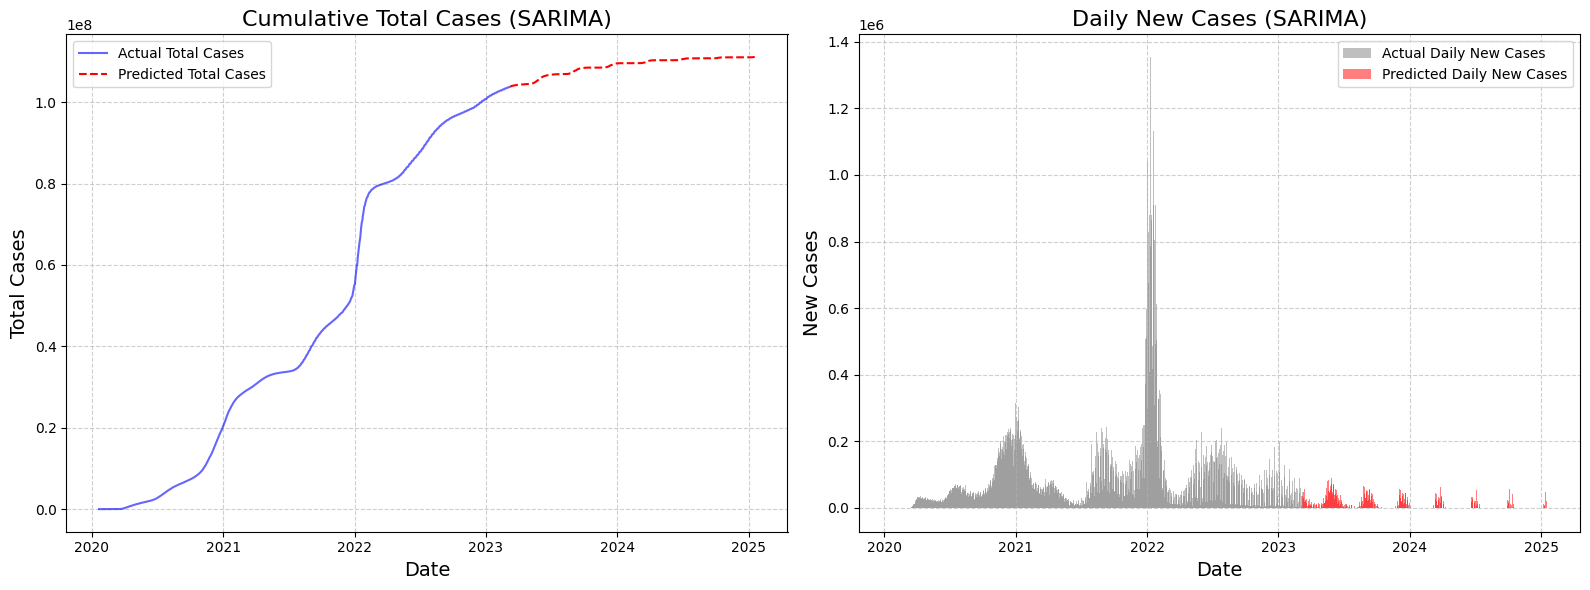

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the date columns
date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata

# Sum all rows to get total cases per date
cumulative_cases = data[date_columns].sum().values.astype(float)

# Convert the date columns to datetime format
dates = pd.to_datetime(date_columns, format='%m/%d/%y')

# Calculate daily new cases
daily_new_cases = np.diff(cumulative_cases, prepend=0)

# Configure SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 100  # Weekly seasonality

# Fit SARIMA model for daily new cases
sarima_model = SARIMAX(daily_new_cases, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit(disp=False)

# Predict future daily new cases up to today's date
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = dates[-1]
days_to_predict = (today - last_date).days

future_predictions = sarima_fit.forecast(steps=days_to_predict)

# Ensure no negative predictions
future_predictions = np.clip(future_predictions, 0, None)

# Convert predicted daily new cases to cumulative cases
predicted_cumulative_cases = np.cumsum(future_predictions) + cumulative_cases[-1]

# Generate future dates
future_dates = [last_date + timedelta(days=i + 1) for i in range(days_to_predict)]

# Plot cumulative total cases and daily new cases
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot cumulative total cases
axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
axes[0].plot(future_dates, predicted_cumulative_cases, label='Predicted Total Cases', color='red', linestyle='--')
axes[0].set_title('Cumulative Total Cases (SARIMA)', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Total Cases', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot daily new cases
axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
axes[1].bar(future_dates, future_predictions, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
axes[1].set_title('Daily New Cases (SARIMA)', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('New Cases', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the list of unique states
unique_states = sorted(data['Province_State'].unique())

# Create dropdown menus for state selection and prediction date
state_dropdown = widgets.Dropdown(
    options=unique_states,
    description='State:',
    layout=widgets.Layout(width='50%')
)

date_picker = widgets.DatePicker(
    description='Prediction Date:',
    disabled=True,  # Initially disabled
    layout=widgets.Layout(width='50%')
)

# Output widget to display results
output = widgets.Output()

def update_date_picker(change):
    # Update the date picker range when a state is selected
    state_name = change['new']
    state_data = data[data['Province_State'] == state_name]

    if not state_data.empty:
        date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata
        last_date = pd.to_datetime(date_columns[-1], format='%m/%d/%y')
        today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))

        # Set the range of the date picker
        date_picker.disabled = False
        date_picker.min = last_date + timedelta(days=1)  # Only allow dates after the last date
        date_picker.max = today
        date_picker.value = today  # Default to today's date

def analyze_state_and_date(change):
    # Clear the output
    with output:
        clear_output(wait=True)

        # Get selected state and prediction date
        state_name = state_dropdown.value
        prediction_date = date_picker.value

        if not state_name or not prediction_date:
            print("Please select a state and a valid prediction date.")
            return

        # Validate the selected prediction date
        date_columns = data.columns[11:]
        last_date = pd.to_datetime(date_columns[-1], format='%m/%d/%y')
        if prediction_date <= last_date:
            print(f"Error: The prediction date must be after {last_date.date()}. Please select another date.")
            return

        print(f"Processing {state_name} for prediction until {prediction_date}...")

        # Filter data for the specified state
        state_data = data[data['Province_State'] == state_name]

        if state_data.empty:
            print(f"State '{state_name}' not found in the dataset.")
        else:
            # Aggregate cases for the selected state
            cumulative_cases = state_data[date_columns].sum().values.astype(float)

            # Handle invalid values in the data
            cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

            # Convert the date columns to datetime format
            dates = pd.to_datetime(date_columns, format='%m/%d/%y')

            # Calculate daily new cases for the selected state
            daily_new_cases = np.diff(cumulative_cases, prepend=0)

            # Configure SARIMA parameters
            p, d, q = 1, 1, 1
            P, D, Q, s = 1, 1, 1, 10  # Monthly seasonality (approximated to 30 days)

            # Fit SARIMA model for daily new cases
            sarima_model = SARIMAX(daily_new_cases, order=(p, d, q), seasonal_order=(P, D, Q, s))
            sarima_fit = sarima_model.fit(disp=False)

            # Calculate days to predict based on user-selected prediction date
            days_to_predict = (prediction_date - last_date).days

            # Predict future daily new cases
            future_predictions = sarima_fit.forecast(steps=days_to_predict)

            # Ensure no negative predictions
            future_predictions = np.clip(future_predictions, 0, None)

            # Convert predicted daily new cases to cumulative cases
            predicted_cumulative_cases = np.cumsum(future_predictions) + cumulative_cases[-1]

            # Generate future dates
            future_dates = [last_date + timedelta(days=i + 1) for i in range(days_to_predict)]

            # Plot cumulative total cases and daily new cases
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Plot cumulative total cases
            axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
            axes[0].plot(future_dates, predicted_cumulative_cases, label='Predicted Total Cases', color='red', linestyle='--')
            axes[0].set_title(f'Cumulative Total Cases (SARIMA) - {state_name}', fontsize=16)
            axes[0].set_xlabel('Date', fontsize=14)
            axes[0].set_ylabel('Total Cases', fontsize=14)
            axes[0].legend()
            axes[0].grid(True, linestyle='--', alpha=0.6)

            # Plot daily new cases
            axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
            axes[1].bar(future_dates, future_predictions, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
            axes[1].set_title(f'Daily New Cases (SARIMA) - {state_name}', fontsize=16)
            axes[1].set_xlabel('Date', fontsize=14)
            axes[1].set_ylabel('New Cases', fontsize=14)
            axes[1].legend()
            axes[1].grid(True, linestyle='--', alpha=0.6)

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()

# Link the state dropdown to update the date picker
state_dropdown.observe(update_date_picker, names='value')

# Link the date picker to analyze the selected state and date
date_picker.observe(analyze_state_and_date, names='value')

# Display the dropdowns and output widgets
display(state_dropdown, date_picker, output)


Dropdown(description='State:', layout=Layout(width='50%'), options=('Alabama', 'Alaska', 'American Samoa', 'Ar…

DatePicker(value=None, description='Prediction Date:', disabled=True, layout=Layout(width='50%'))

Output()

Splitting into counties

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Ensure the dataset contains 'Admin2' (counties) and case columns
if 'Admin2' not in data.columns:
    raise ValueError("The dataset must have an 'Admin2' column.")

# Extract the date columns (assuming the first 11 columns are metadata)
date_columns = data.columns[11:]

# Sum cases for each county (Admin2) grouped by 'Admin2' and 'Province_State' for uniqueness
county_sums = data.groupby(['Province_State', 'Admin2'])[date_columns].sum()

# Reset index to save as a clean DataFrame
county_sums.reset_index(inplace=True)

# Save the new dataset
output_file = '/content/county_sums.csv'  # Change the file path if needed
county_sums.to_csv(output_file, index=False)
print(f"Dataset saved to {output_file}")

# Preview the new dataset
print(county_sums.head())


Dataset saved to /content/county_sums.csv
  Province_State   Admin2  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0        Alabama  Autauga        0        0        0        0        0   
1        Alabama  Baldwin        0        0        0        0        0   
2        Alabama  Barbour        0        0        0        0        0   
3        Alabama     Bibb        0        0        0        0        0   
4        Alabama   Blount        0        0        0        0        0   

   1/27/20  1/28/20  1/29/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  3/4/23  \
0        0        0        0  ...    19732   19759   19759   19759   19759   
1        0        0        0  ...    69641   69767   69767   69767   69767   
2        0        0        0  ...     7451    7474    7474    7474    7474   
3        0        0        0  ...     8067    8087    8087    8087    8087   
4        0        0        0  ...    18616   18673   18673   18673   18673   

   3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_US.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path)

# Extract the list of unique states
unique_states = sorted(data['Province_State'].unique())

# Create dropdown menus for state and county selection, and a date picker
state_dropdown = widgets.Dropdown(
    options=unique_states,
    description='State:',
    layout=widgets.Layout(width='50%')
)

county_dropdown = widgets.Dropdown(
    options=[],
    description='County:',
    layout=widgets.Layout(width='50%')
)

date_picker = widgets.DatePicker(
    description='Prediction Date:',
    disabled=True,  # Initially disabled
    layout=widgets.Layout(width='50%')
)

# Output widget to display results
output = widgets.Output()

def update_counties(change):
    # Update the county dropdown and date picker when a state is selected
    with output:
        clear_output(wait=True)

    state_name = change['new']
    counties = sorted(data[data['Province_State'] == state_name]['Admin2'].unique())
    county_dropdown.options = counties

    # Set up the date picker range based on the dataset
    if counties:
        state_data = data[data['Province_State'] == state_name]
        date_columns = data.columns[11:]  # Assuming the first 11 columns are metadata
        last_date = pd.to_datetime(date_columns[-1], format='%m/%d/%y')
        today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))

        date_picker.disabled = False
        date_picker.min = last_date + timedelta(days=1)  # Only allow dates after the last date
        date_picker.max = today
        date_picker.value = today

def analyze_county(change):
    # Clear the output
    with output:
        clear_output(wait=True)

        # Get selected state, county, and prediction date
        state_name = state_dropdown.value
        county_name = county_dropdown.value
        prediction_date = date_picker.value

        if not state_name or not county_name or not prediction_date:
            print("Please select a state, county, and a valid prediction date.")
            return

        # Validate the selected prediction date
        date_columns = data.columns[11:]
        last_date = pd.to_datetime(date_columns[-1], format='%m/%d/%y')
        if prediction_date <= last_date:
            print(f"Error: The prediction date must be after {last_date.date()}. Please select another date.")
            return

        print(f"Processing {county_name}, {state_name} for prediction until {prediction_date}...")

        # Filter data for the specified county
        county_data = data[(data['Province_State'] == state_name) & (data['Admin2'] == county_name)]

        if county_data.empty:
            print(f"County '{county_name}' not found in the dataset.")
        else:
            # Get cumulative cases for the selected county
            cumulative_cases = county_data[date_columns].sum().values.astype(float)

            # Handle invalid values in the data
            cumulative_cases = np.nan_to_num(cumulative_cases, nan=0, posinf=0, neginf=0)

            # Convert the date columns to datetime format
            dates = pd.to_datetime(date_columns, format='%m/%d/%y')

            # Calculate daily new cases for the selected county
            daily_new_cases = np.diff(cumulative_cases, prepend=0)

            # Configure SARIMA parameters
            p, d, q = 1, 1, 1
            P, D, Q, s = 1, 1, 1, 10  # Monthly seasonality (approximated to 30 days)

            # Fit SARIMA model for daily new cases
            sarima_model = SARIMAX(daily_new_cases, order=(p, d, q), seasonal_order=(P, D, Q, s))
            sarima_fit = sarima_model.fit(disp=False)

            # Calculate days to predict based on user-selected prediction date
            days_to_predict = (prediction_date - last_date).days

            # Predict future daily new cases
            future_predictions = sarima_fit.forecast(steps=days_to_predict)

            # Ensure no negative predictions
            future_predictions = np.clip(future_predictions, 0, None)

            # Convert predicted daily new cases to cumulative cases
            predicted_cumulative_cases = np.cumsum(future_predictions) + cumulative_cases[-1]

            # Generate future dates
            future_dates = [last_date + timedelta(days=i + 1) for i in range(days_to_predict)]

            # Plot cumulative total cases and daily new cases
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Plot cumulative total cases
            axes[0].plot(dates, cumulative_cases, label='Actual Total Cases', color='blue', alpha=0.6)
            axes[0].plot(future_dates, predicted_cumulative_cases, label='Predicted Total Cases', color='red', linestyle='--')
            axes[0].set_title(f'Cumulative Total Cases (SARIMA) - {county_name}, {state_name}', fontsize=16)
            axes[0].set_xlabel('Date', fontsize=14)
            axes[0].set_ylabel('Total Cases', fontsize=14)
            axes[0].legend()
            axes[0].grid(True, linestyle='--', alpha=0.6)

            # Plot daily new cases
            axes[1].bar(dates, daily_new_cases, label='Actual Daily New Cases', color='gray', alpha=0.5, width=2)
            axes[1].bar(future_dates, future_predictions, label='Predicted Daily New Cases', color='red', alpha=0.5, width=2)
            axes[1].set_title(f'Daily New Cases (SARIMA) - {county_name}, {state_name}', fontsize=16)
            axes[1].set_xlabel('Date', fontsize=14)
            axes[1].set_ylabel('New Cases', fontsize=14)
            axes[1].legend()
            axes[1].grid(True, linestyle='--', alpha=0.6)

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()

# Link the state dropdown to update the counties and date picker
state_dropdown.observe(update_counties, names='value')

# Link the county dropdown to analyze the selected county
county_dropdown.observe(analyze_county, names='value')

# Link the date picker to analyze the selected county
date_picker.observe(analyze_county, names='value')

# Display the dropdowns, date picker, and output widgets
display(state_dropdown, county_dropdown, date_picker, output)


Dropdown(description='State:', layout=Layout(width='50%'), options=('Alabama', 'Alaska', 'American Samoa', 'Ar…

Dropdown(description='County:', layout=Layout(width='50%'), options=(), value=None)

DatePicker(value=None, description='Prediction Date:', disabled=True, layout=Layout(width='50%'))

Output()

Shapefile predictions


In [ ]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()


Saving cb_2018_us_state_500k.zip to cb_2018_us_state_500k.zip


In [ ]:
import zipfile
import os

# Specify the uploaded ZIP file name
zip_file_name = "cb_2018_us_state_500k.zip"

# Extract the shapefile
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("shapefile_data")

# Verify extracted files
print(os.listdir("shapefile_data"))


['cb_2018_us_state_500k.cpg', 'cb_2018_us_state_500k.shp.iso.xml', 'cb_2018_us_state_500k.shx', 'cb_2018_us_state_500k.dbf', 'cb_2018_us_state_500k.shp.ea.iso.xml', 'cb_2018_us_state_500k.prj', 'cb_2018_us_state_500k.shp']


In [ ]:
!pip install geopandas matplotlib


In [ ]:
# Install required libraries (run this once in Colab)
!pip install geopandas matplotlib shapely pandas seaborn ipywidgets

# Import necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd
import seaborn as sns
from ipywidgets import interact, IntSlider
from IPython.display import clear_output
from shapely.geometry import MultiPolygon, Polygon

In [ ]:
# Install required libraries (run this once in Colab)
!pip install geopandas matplotlib shapely pandas seaborn ipywidgets

# Import necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd
import seaborn as sns
from ipywidgets import interact, IntSlider
from IPython.display import clear_output

# Load shapefile (state-level boundaries)
shapefile_path = "shapefile_data/cb_2018_us_state_500k.shp"
usa_states = gpd.read_file(shapefile_path)

# Load COVID-19 data
csv_file = "time_series_covid19_confirmed_US.csv"
covid_data = pd.read_csv(csv_file)

# Filter Mainland USA states
mainland_states = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
    "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA",
    "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA",
    "WV", "WI", "WY"
]
filtered_usa = usa_states[usa_states["STUSPS"].isin(mainland_states)]

# Create GeoDataFrame for COVID-19 data with coordinates
gdf_cities = gpd.GeoDataFrame(
    covid_data,
    geometry=gpd.points_from_xy(covid_data.Long_, covid_data.Lat),
    crs="EPSG:4326"
)

# Filter COVID-19 data to include only cities within valid regions
filtered_covid_data = gpd.sjoin(gdf_cities, filtered_usa, how="inner", predicate="within")

# Extract date columns
date_columns = covid_data.columns[11:]  # Assuming date columns start from column 12

# Convert all date columns to numeric, replacing non-numeric values with 0
covid_data[date_columns] = covid_data[date_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

# Get the maximum number of cases on the last day
max_cases_last_day = covid_data[date_columns[-1]].max()

# Define the plotting function
def plot_heatmap_colab(date_index):
    # Clear previous outputs
    clear_output(wait=True)

    # Get the selected date
    date = date_columns[date_index]
    print(f"Displaying heatmap for: {date}")

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot the state boundaries
    filtered_usa.boundary.plot(ax=ax, linewidth=1, color="black")

    # Filter COVID-19 data for the selected date
    filtered_covid_data["cases"] = filtered_covid_data[date]
    heatmap_data = filtered_covid_data[["geometry", "cases"]].dropna()

    # Normalize weights for consistent scaling
    normalized_weights = heatmap_data["cases"] / max_cases_last_day

    # Generate the heatmap using seaborn with rainbow colormap
    sns.kdeplot(
        x=heatmap_data.geometry.x,
        y=heatmap_data.geometry.y,
        weights=normalized_weights,
        ax=ax,
        cmap="rainbow",
        fill=True,
        alpha=0.6,
        bw_adjust=0.5
    )

    # Add a colorbar for the legend
    norm = Normalize(vmin=0, vmax=max_cases_last_day)
    sm = ScalarMappable(cmap="rainbow", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.02)
    cbar.set_label("Number of Cases", fontsize=12)

    # Add plot title and hide axes
    ax.set_title(f"COVID-19 Case Heatmap - {date}", fontsize=16)
    ax.axis("off")
    plt.show()

# Create an interactive widget in Colab using the plot function
interact(plot_heatmap_colab, date_index=IntSlider(0, 0, len(date_columns) - 1))


<ipython-input-8-e324511a3967>:41: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  filtered_covid_data = gpd.sjoin(gdf_cities, filtered_usa, how="inner", predicate="within")


interactive(children=(IntSlider(value=0, description='date_index', max=1142), Output()), _dom_classes=('widget…

SARIMA predicted heat maps

In [ ]:
# Install required libraries (run this once in Colab)
!pip install statsmodels pandas

# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta

# Load COVID-19 data
csv_file = "time_series_covid19_confirmed_US.csv"
covid_data = pd.read_csv(csv_file)

# Extract date columns
date_columns = covid_data.columns[11:]  # Assuming date columns start from column 12

# Convert date columns to numeric
covid_data[date_columns] = covid_data[date_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

# Predict future cases using SARIMA
def predict_with_sarima(data, date_columns, days_to_predict):
    # Initialize a DataFrame to store predictions
    predictions = data.copy()
    today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
    last_date = pd.to_datetime(date_columns[-1], format="%m/%d/%y")
    prediction_dates = [last_date + timedelta(days=i + 1) for i in range(days_to_predict)]

    for index, row in data.iterrows():
        # Extract cumulative cases
        cumulative_cases = row[date_columns].values.astype(float)

        # Calculate daily new cases
        daily_new_cases = np.diff(cumulative_cases, prepend=0)

        # Fit SARIMA model
        try:
            sarima_model = SARIMAX(daily_new_cases, order=(1, 1, 1), seasonal_order=(1, 1, 1, 3))
            sarima_fit = sarima_model.fit(disp=False)

            # Predict future daily new cases
            future_predictions = sarima_fit.forecast(steps=days_to_predict)
            future_predictions = np.clip(future_predictions, 0, None)  # Ensure no negative predictions

            # Convert daily predictions to cumulative predictions
            predicted_cumulative = np.cumsum(future_predictions) + cumulative_cases[-1]

            # Add predictions to the DataFrame
            for i, pred_date in enumerate(prediction_dates):
                predictions.loc[index, str(pred_date.date())] = predicted_cumulative[i]
        except Exception as e:
            print(f"Error predicting for row {index}: {e}")
            continue

    return predictions, prediction_dates

# Number of days to predict
today = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
last_date = pd.to_datetime(date_columns[-1], format="%m/%d/%y")
days_to_predict = (today - last_date).days

# Predict cases
predicted_data, prediction_dates = predict_with_sarima(covid_data, date_columns, days_to_predict)

# Save predictions to a CSV file
output_csv_file = "predicted_covid19_cases.csv"
predicted_data.to_csv(output_csv_file, index=False)
print(f"Predictions saved to {output_csv_file}")


<ipython-input-91-f14099aab7a3>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictions.loc[index, str(pred_date.date())] = predicted_cumulative[i]
<ipython-input-91-f14099aab7a3>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictions.loc[index, str(pred_date.date())] = predicted_cumulative[i]
<ipython-input-91-f14099aab7a3>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

Predictions saved to predicted_covid19_cases.csv


<ipython-input-88-8c21e010ae21>:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  filtered_covid_data = gpd.sjoin(gdf_cities, filtered_usa, how="inner", predicate="within")


Error predicting for row 0: Seasonal periodicity must be greater than 1.
Error predicting for row 1: Seasonal periodicity must be greater than 1.
Error predicting for row 2: Seasonal periodicity must be greater than 1.
Error predicting for row 3: Seasonal periodicity must be greater than 1.
Error predicting for row 4: Seasonal periodicity must be greater than 1.
Error predicting for row 5: Seasonal periodicity must be greater than 1.
Error predicting for row 6: Seasonal periodicity must be greater than 1.
Error predicting for row 7: Seasonal periodicity must be greater than 1.
Error predicting for row 8: Seasonal periodicity must be greater than 1.
Error predicting for row 9: Seasonal periodicity must be greater than 1.
Error predicting for row 10: Seasonal periodicity must be greater than 1.
Error predicting for row 11: Seasonal periodicity must be greater than 1.
Error predicting for row 12: Seasonal periodicity must be greater than 1.
Error predicting for row 13: Seasonal periodicit

interactive(children=(IntSlider(value=0, description='date_index', max=679), Output()), _dom_classes=('widget-…

<function __main__.plot_predicted_heatmap(date_index)>

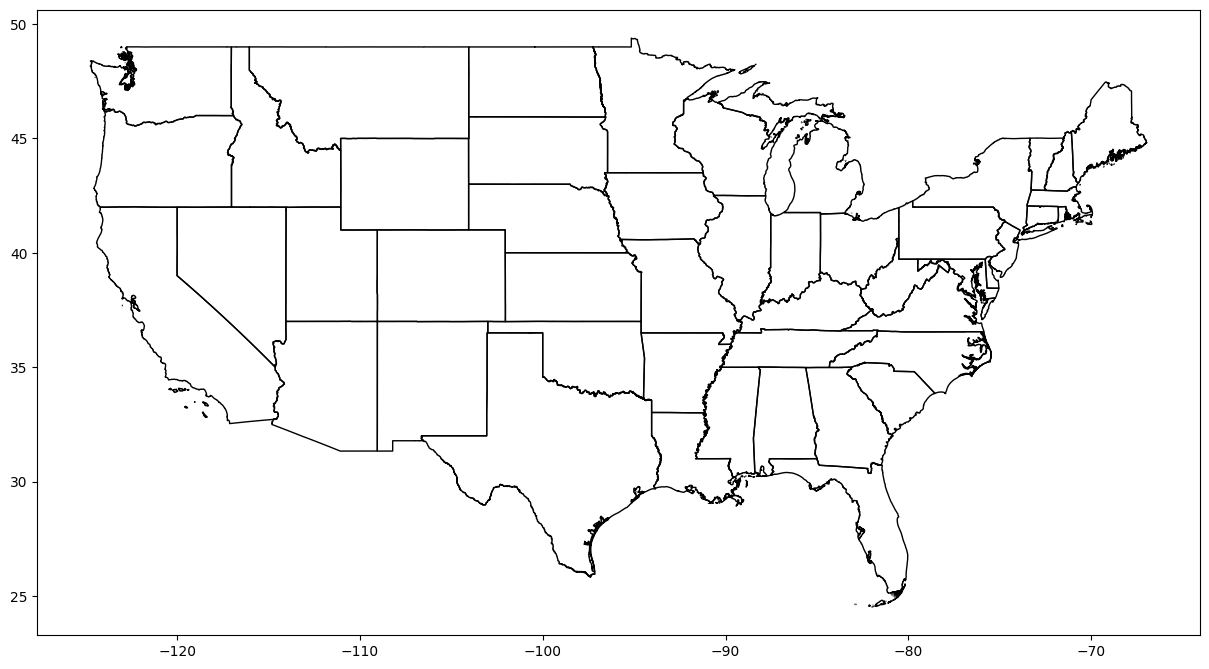

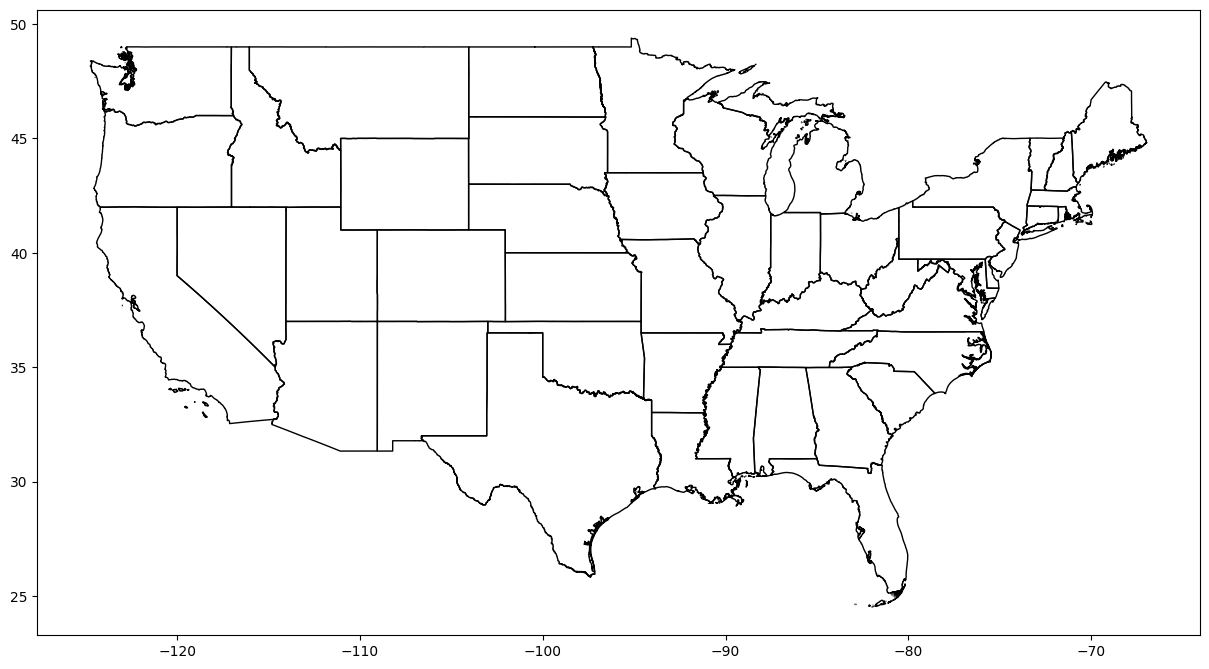

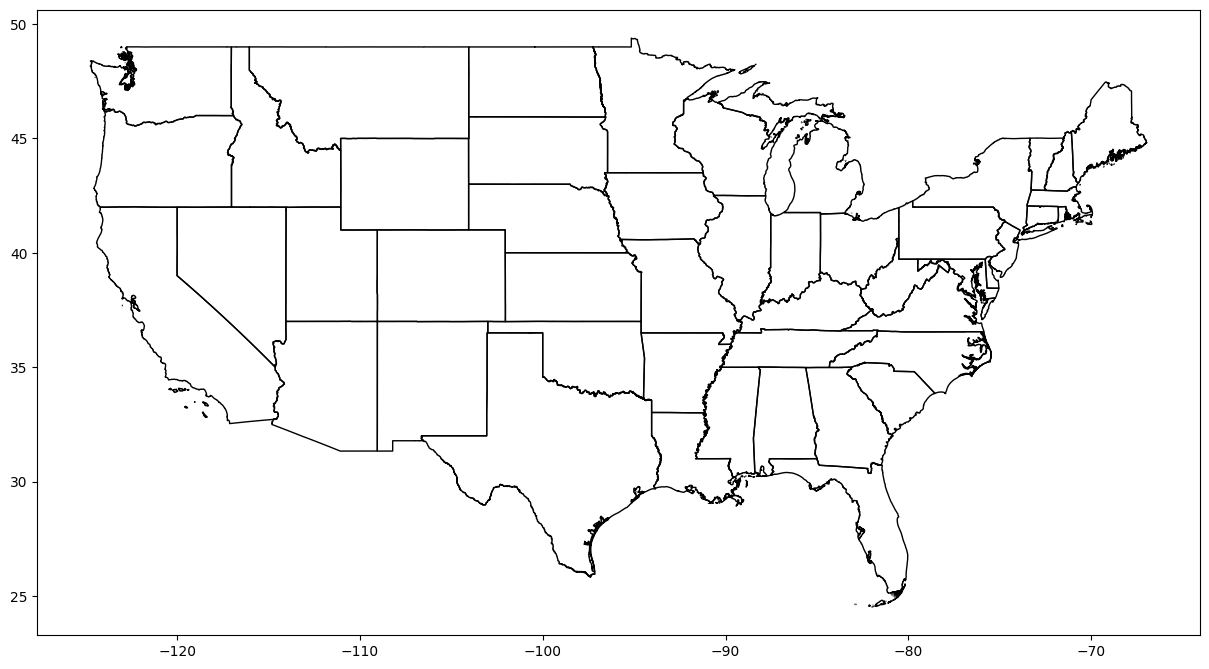

In [ ]:
# Install required libraries (run this once in Colab)
!pip install geopandas matplotlib seaborn ipywidgets

# Import necessary libraries
import geopandas as gpd
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import clear_output

# Load shapefile (state-level boundaries)
shapefile_path = "shapefile_data/cb_2018_us_state_500k.shp"
usa_states = gpd.read_file(shapefile_path)

# Filter Mainland USA states
mainland_states = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
    "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA",
    "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA",
    "WV", "WI", "WY"
]
filtered_usa = usa_states[usa_states["STUSPS"].isin(mainland_states)]

# Load the predictions CSV file
predicted_csv_file = "predicted_covid19_cases.csv"
predicted_data = pd.read_csv(predicted_csv_file)

# Create GeoDataFrame for predicted data with coordinates
predicted_gdf = gpd.GeoDataFrame(
    predicted_data, geometry=gpd.points_from_xy(predicted_data.Long_, predicted_data.Lat)
)

# Define the plotting function
def plot_predicted_heatmap(date_index):
    # Clear previous outputs
    clear_output(wait=True)

    # Get the selected date
    date = prediction_dates[date_index].strftime("%Y-%m-%d")
    print(f"Displaying predicted heatmap for: {date}")

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot the state boundaries
    filtered_usa.boundary.plot(ax=ax, linewidth=1, color="black")

    # Filter COVID-19 data for the selected date
    predicted_gdf["cases"] = predicted_gdf[date]
    heatmap_data = predicted_gdf[["geometry", "cases"]].dropna()

    # Normalize weights for consistent scaling
    max_cases = predicted_gdf[date].max()
    normalized_weights = heatmap_data["cases"] / max_cases

    # Generate the heatmap using seaborn with rainbow colormap
    sns.kdeplot(
        x=heatmap_data.geometry.x,
        y=heatmap_data.geometry.y,
        weights=normalized_weights,
        ax=ax,
        cmap="rainbow",
        fill=True,
        alpha=0.6,
        bw_adjust=0.5
    )

    # Add a colorbar for the legend
    norm = Normalize(vmin=0, vmax=max_cases)
    sm = ScalarMappable(cmap="rainbow", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.02)
    cbar.set_label("Number of Cases", fontsize=12)

    # Add plot title and hide axes
    ax.set_title(f"Predicted COVID-19 Case Heatmap - {date}", fontsize=16)
    ax.axis("off")
    plt.show()

# Create an interactive widget
interact(plot_predicted_heatmap, date_index=IntSlider(0, 0, len(prediction_dates) - 1))


In [ ]:
# Install required libraries (run this once in Colab)
!pip install geopandas matplotlib shapely pandas seaborn ipywidgets

# Import necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely.geometry import MultiPolygon, Polygon
import pandas as pd
import seaborn as sns
from ipywidgets import interact, Dropdown, IntSlider
from IPython.display import clear_output


interactive(children=(Dropdown(description='State:', index=5, options=('Alabama', 'Alaska', 'American Samoa', …

<function __main__.plot_state_heatmap(state_name, date_index)>

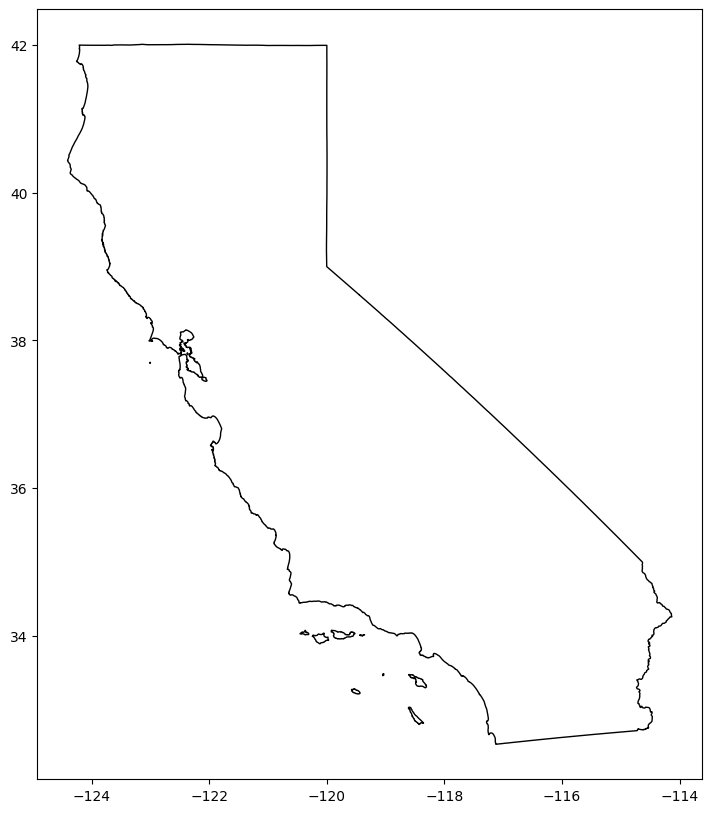

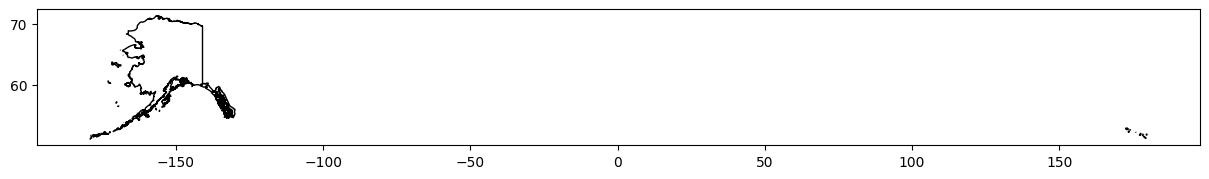

In [ ]:

# Load shapefile
shapefile_path = "shapefile_data/cb_2018_us_state_500k.shp"
usa_states = gpd.read_file(shapefile_path)

# Load COVID-19 data
csv_file = "time_series_covid19_confirmed_US.csv"
covid_data = pd.read_csv(csv_file)

# Extract state names from the shapefile
state_names = sorted(usa_states["NAME"].unique())

# Extract date columns
date_columns = covid_data.columns[11:]  # Assuming date columns start from column 12

# Convert all date columns to numeric, replacing non-numeric values with 0
covid_data[date_columns] = covid_data[date_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

# Function to plot heatmaps for a selected state
def plot_state_heatmap(state_name, date_index):
    # Clear previous outputs
    clear_output(wait=True)

    # Get the selected date
    date = date_columns[date_index]
    print(f"Displaying heatmap for {state_name} on {date}")

    # Filter the shapefile for the selected state
    state_shape = usa_states[usa_states["NAME"] == state_name]

    # Filter the COVID-19 data for the selected state
    state_covid_data = covid_data[covid_data["Province_State"] == state_name]

    if state_shape.empty or state_covid_data.empty:
        print(f"No data available for {state_name}.")
        return

    # Create GeoDataFrame for the selected state COVID-19 data
    state_gdf = gpd.GeoDataFrame(
        state_covid_data,
        geometry=gpd.points_from_xy(state_covid_data.Long_, state_covid_data.Lat),
        crs="EPSG:4326"
    )

    # Get the maximum number of cases for normalization
    max_cases_last_day = state_covid_data[date_columns[-1]].max()

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot the state boundary
    state_shape.boundary.plot(ax=ax, linewidth=1, color="black")

    # Filter COVID-19 data for the selected date
    state_gdf["cases"] = state_gdf[date]
    heatmap_data = state_gdf[["geometry", "cases"]].dropna()

    # Normalize weights for consistent scaling
    normalized_weights = heatmap_data["cases"] / max_cases_last_day

    # Generate the heatmap using seaborn with rainbow colormap
    sns.kdeplot(
        x=heatmap_data.geometry.x,
        y=heatmap_data.geometry.y,
        weights=normalized_weights,
        ax=ax,
        cmap="rainbow",  # Use the rainbow colormap
        fill=True,
        alpha=0.6,
        bw_adjust=0.5
    )

    # Add a colorbar for the legend
    norm = Normalize(vmin=0, vmax=max_cases_last_day)  # Scale from 0 to max cases on the last day
    sm = ScalarMappable(cmap="rainbow", norm=norm)
    sm.set_array([])  # Required for the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.02)
    cbar.set_label("Number of Cases", fontsize=12)

    # Add plot title and hide axes
    ax.set_title(f"COVID-19 Case Heatmap - {state_name} on {date}", fontsize=16)
    ax.axis("off")
    plt.show()

# Create dropdown and slider widgets
state_dropdown = Dropdown(
    options=state_names,  # List of state names
    description="State:",
    value="California"  # Default to California
)
date_slider = IntSlider(
    min=0,
    max=len(date_columns) - 1,
    step=1,
    value=0,
    description="Date Index"
)

# Interactive plotting
interact(plot_state_heatmap, state_name=state_dropdown, date_index=date_slider)


In [ ]:
# Install required libraries (run this once in Colab)
!pip install geopandas matplotlib shapely pandas ipywidgets

# Import necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, Dropdown, IntSlider
from IPython.display import clear_output

In [ ]:


# Load shapefile (state-level boundaries)
shapefile_path = "shapefile_data/cb_2018_us_state_500k.shp"  # State-level shapefile
usa_states = gpd.read_file(shapefile_path)

# Load COVID-19 data
csv_file = "time_series_covid19_confirmed_US.csv"
covid_data = pd.read_csv(csv_file)

# Extract state names
state_names = sorted(covid_data["Province_State"].unique())

# Extract date columns
date_columns = covid_data.columns[11:]  # Assuming date columns start from column 12

# Convert all date columns to numeric, replacing non-numeric values with 0
covid_data[date_columns] = covid_data[date_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

# Define a function to plot new cases as dots
def plot_new_cases(state_name, date_index):
    # Clear previous outputs
    clear_output(wait=True)

    # Get the selected date
    date = date_columns[date_index]
    print(f"Displaying new cases for counties in {state_name} on {date}")

    # Filter the shapefile for the selected state
    state_shape = usa_states[usa_states["NAME"] == state_name]

    # Filter the COVID-19 data for the selected state
    state_covid_data = covid_data[covid_data["Province_State"] == state_name]

    if state_shape.empty or state_covid_data.empty:
        print(f"No data available for {state_name}.")
        return

    # Compute daily new cases
    state_covid_data["new_cases"] = (
        state_covid_data[date] - state_covid_data[date_columns[max(0, date_index - 1)]]
    )
    state_covid_data["new_cases"] = state_covid_data["new_cases"].clip(lower=0)  # Ensure no negative values

    # Create GeoDataFrame for the selected state COVID-19 data
    state_gdf = gpd.GeoDataFrame(
        state_covid_data,
        geometry=gpd.points_from_xy(state_covid_data.Long_, state_covid_data.Lat),
        crs="EPSG:4326"
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the state boundary
    state_shape.boundary.plot(ax=ax, color="black", linewidth=1)

    # Plot new cases as dots
    state_gdf.plot(
        ax=ax,
        color="red",
        markersize=state_gdf["new_cases"] / 10,  # Scale marker size
        alpha=0.7
    )

    # Add title and hide axes
    ax.set_title(f"New COVID-19 Cases by County - {state_name} on {date}", fontsize=16)
    ax.axis("off")
    plt.show()

# Create dropdowns for state selection
state_dropdown = Dropdown(
    options=state_names,
    description="State:",
    value="California"  # Default to California
)

# Create a slider for selecting the date index
date_slider = IntSlider(
    min=0,
    max=len(date_columns) - 1,
    step=1,
    value=0,
    description="Date Index"
)

# Interactive plotting
interact(
    plot_new_cases,
    state_name=state_dropdown,
    date_index=date_slider
)


interactive(children=(Dropdown(description='State:', index=5, options=('Alabama', 'Alaska', 'American Samoa', …

<function __main__.plot_new_cases(state_name, date_index)>

In [ ]:
# Install required libraries (run this once in Colab)
!pip install geopandas matplotlib shapely pandas ipywidgets

# Import necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, Dropdown, IntSlider
from IPython.display import clear_output

In [ ]:


# Load shapefile (state-level boundaries)
shapefile_path = "shapefile_data/cb_2018_us_state_500k.shp"  # State-level shapefile
usa_states = gpd.read_file(shapefile_path)

# Load COVID-19 data
csv_file = "time_series_covid19_confirmed_US.csv"
covid_data = pd.read_csv(csv_file)

# Extract state and county names
state_names = sorted(covid_data["Province_State"].unique())
county_names_by_state = {
    state: sorted(covid_data[covid_data["Province_State"] == state]["Admin2"].unique())
    for state in state_names
}

# Extract date columns
date_columns = covid_data.columns[11:]  # Assuming date columns start from column 12

# Convert all date columns to numeric, replacing non-numeric values with 0
covid_data[date_columns] = covid_data[date_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

# Define a function to plot new cases as dots for a specific county
def plot_new_cases(state_name, county_name, date_index):
    # Clear previous outputs
    clear_output(wait=True)

    # Get the selected date
    date = date_columns[date_index]
    print(f"Displaying new cases for {county_name}, {state_name} on {date}")

    # Filter the shapefile for the selected state
    state_shape = usa_states[usa_states["NAME"] == state_name]

    # Filter the COVID-19 data for the selected state and county
    county_covid_data = covid_data[
        (covid_data["Province_State"] == state_name) & (covid_data["Admin2"] == county_name)
    ]

    if state_shape.empty or county_covid_data.empty:
        print(f"No data available for {county_name}, {state_name}.")
        return

    # Compute daily new cases
    county_covid_data["new_cases"] = (
        county_covid_data[date] - county_covid_data[date_columns[max(0, date_index - 1)]]
    )
    county_covid_data["new_cases"] = county_covid_data["new_cases"].clip(lower=0)  # Ensure no negative values

    # Create GeoDataFrame for the selected county COVID-19 data
    county_gdf = gpd.GeoDataFrame(
        county_covid_data,
        geometry=gpd.points_from_xy(county_covid_data.Long_, county_covid_data.Lat),
        crs="EPSG:4326"
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the state boundary
    state_shape.boundary.plot(ax=ax, color="black", linewidth=1)

    # Plot new cases as dots
    county_gdf.plot(
        ax=ax,
        color="red",
        markersize=county_gdf["new_cases"] / 10,  # Scale marker size
        alpha=0.7
    )

    # Add title and hide axes
    ax.set_title(f"New COVID-19 Cases - {county_name}, {state_name} on {date}", fontsize=16)
    ax.axis("off")
    plt.show()

# Create dropdowns for state and county selection
state_dropdown = Dropdown(
    options=state_names,
    description="State:",
    value="California"  # Default to California
)

county_dropdown = Dropdown(
    options=county_names_by_state["California"],  # Default counties for California
    description="County:",
    value="Los Angeles"  # Default to Los Angeles
)

# Function to update county dropdown based on selected state
def update_county_dropdown(state_name):
    county_dropdown.options = county_names_by_state[state_name]
    county_dropdown.value = county_names_by_state[state_name][0]

# Observe changes in the state dropdown to update counties
state_dropdown.observe(lambda change: update_county_dropdown(state_dropdown.value), names="value")

# Create a slider for selecting the date index
date_slider = IntSlider(
    min=0,
    max=len(date_columns) - 1,
    step=1,
    value=0,
    description="Date Index"
)

# Interactive plotting
interact(
    plot_new_cases,
    state_name=state_dropdown,
    county_name=county_dropdown,
    date_index=date_slider
)


interactive(children=(Dropdown(description='State:', index=5, options=('Alabama', 'Alaska', 'American Samoa', …

<function __main__.plot_new_cases(state_name, county_name, date_index)>